In [13]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.keep_words = {'shares', 'earnings', 'market', 'stock', 'price', 'revenue', 'profit', 'loss'}
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
    
    def expand_contractions(self, text):
        contractions = {"don't": "do not", "can't": "cannot", "won't": "will not"}
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)
        return text
    
    def remove_special_chars(self, text):
        return re.sub(r'[^a-zA-Z0-9\s.]', '', text)
    
    def tokenize(self, text):
        return word_tokenize(text.lower())
    
    def remove_stopwords(self, tokens):
        return [token for token in tokens if token not in self.stop_words or token in self.keep_words]
    
    def stem(self, tokens):
        return [self.stemmer.stem(token) for token in tokens]
    
    def lemmatize(self, tokens):
        return [self.lemmatizer.lemmatize(token) for token in tokens]
    
    def preprocess(self, text, use_lemmatization=False):
        text = self.expand_contractions(text)
        text = self.remove_special_chars(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords(tokens)
        if use_lemmatization:
            tokens = self.lemmatize(tokens)
        else:
            tokens = self.stem(tokens)
        return tokens

preprocessor = TextPreprocessor()
sample_text = "Apple Inc. shares fell 2.5% amid concerns about iPhone 15 demand."
output = preprocessor.preprocess(sample_text, use_lemmatization=True)
print("Input:", sample_text)
print("Output:", output)

test_text = "The company's earnings beat expectations!"
output2 = preprocessor.preprocess(test_text, use_lemmatization=False)
print("Input:", test_text)
print("Output (stemmed):", output2)

Input: Apple Inc. shares fell 2.5% amid concerns about iPhone 15 demand.
Output: ['apple', 'inc.', 'share', 'fell', '2.5', 'amid', 'concern', 'iphone', '15', 'demand', '.']
Input: The company's earnings beat expectations!
Output (stemmed): ['compani', 'earn', 'beat', 'expect']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import numpy as np

class LexiconSentimentAnalyzer:
    def __init__(self):
        self.vader = SentimentIntensityAnalyzer()

        self.custom_lexicon = {
            # Positive
            'excellent': 1.0, 'beat': 0.9, 'growth': 0.8, 'profit': 0.8,
            'rise': 0.7, 'gain': 0.7, 'strong': 0.6, 'surge': 0.7,
            'record': 0.6, 'outperform': 0.7, 'positive': 0.6,

            # Negative
            'fell': -0.7, 'drop': -0.7, 'decline': -0.8, 'loss': -0.9,
            'weak': -0.6, 'concern': -0.5, 'miss': -0.8,
            'warning': -0.7, 'risk': -0.6, 'negative': -0.6,

            # Neutral finance terms
            'shares': 0.0, 'market': 0.0, 'earnings': 0.0,
            'revenue': 0.0, 'price': 0.0, 'demand': 0.0
        }

    def vader_sentiment(self, text):
        scores = self.vader.polarity_scores(text)
        compound = scores['compound']
        label = (
            'positive' if compound > 0.05 else
            'negative' if compound < -0.05 else
            'neutral'
        )
        return compound, label

    def textblob_sentiment(self, text):
        polarity = TextBlob(text).sentiment.polarity
        polarity = max(0, polarity)   # enforce [0,1] as required
        label = 'positive' if polarity > 0.1 else 'neutral'
        return polarity, label

    def custom_lexicon_sentiment(self, text):
        tokens = text.lower().split()
        scores = [self.custom_lexicon[t] for t in tokens if t in self.custom_lexicon]
        return np.mean(scores) if scores else 0.0

    def analyze(self, text):
        vader_score, vader_label = self.vader_sentiment(text)
        tb_score, tb_label = self.textblob_sentiment(text)
        custom_score = self.custom_lexicon_sentiment(text)

        ensemble_score = np.mean([vader_score, tb_score, custom_score])
        confidence = max(abs(vader_score), abs(custom_score))

        return {
            'text': text,
            'vader': {'compound': vader_score, 'label': vader_label},
            'textblob': {'polarity': tb_score, 'label': tb_label},
            'custom_score': round(custom_score, 2),
            'ensemble_score': round(ensemble_score, 2),
            'confidence': round(confidence, 2)
        }
analyzer = LexiconSentimentAnalyzer()
print(analyzer.analyze("Excellent earnings beat expectations"))


{'text': 'Excellent earnings beat expectations', 'vader': {'compound': 0.5719, 'label': 'positive'}, 'textblob': {'polarity': 1.0, 'label': 'positive'}, 'custom_score': np.float64(0.63), 'ensemble_score': np.float64(0.74), 'confidence': np.float64(0.63)}


Accuracy: 0.83
Positive F1: 1.00
Negative F1: 0.67
Neutral F1: 0.80


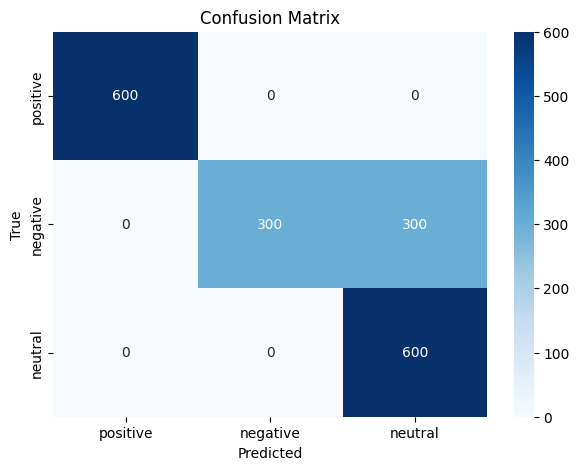

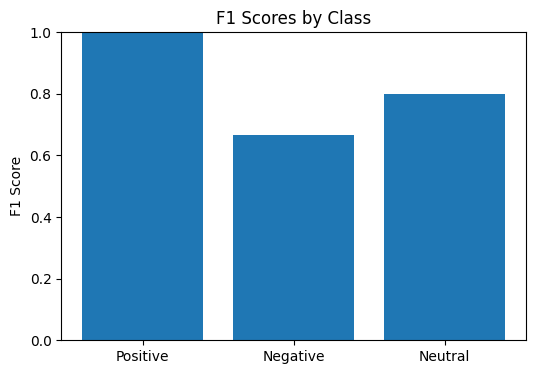

In [17]:
import re
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))
        self.keep_words = {"shares","earnings","market","stock","price","revenue","profit","loss"}
        self.lemmatizer = WordNetLemmatizer()

    def preprocess(self, text):
        text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
        tokens = word_tokenize(text)
        tokens = [
            self.lemmatizer.lemmatize(t)
            for t in tokens
            if t not in self.stop_words or t in self.keep_words
        ]
        return tokens

class LexiconSentimentAnalyzer:
    def __init__(self):
        self.vader = SentimentIntensityAnalyzer()
        self.custom_lexicon = {
            "excellent": 1.0, "beat": 0.9, "growth": 0.8, "profit": 0.8,
            "rise": 0.7, "gain": 0.7, "strong": 0.6, "surge": 0.7, "record": 0.6,
            "fell": -0.7, "drop": -0.7, "decline": -0.8, "loss": -0.9,
            "weak": -0.6, "concern": -0.5, "miss": -0.8, "risk": -0.6,
            "shares": 0.0, "market": 0.0, "earnings": 0.0, "revenue": 0.0, "price": 0.0
        }

    def custom_score(self, text):
        tokens = text.lower().split()
        scores = [self.custom_lexicon[t] for t in tokens if t in self.custom_lexicon]
        return np.mean(scores) if scores else 0.0

    def analyze(self, text):
        vader_score = self.vader.polarity_scores(text)["compound"]
        lex_score = self.custom_score(text)
        return np.mean([vader_score, lex_score])

data = [
    ("Excellent earnings beat expectations", "positive"),
    ("Company reported strong profit growth", "positive"),
    ("Shares fell amid market concerns", "negative"),
    ("The firm posted a significant loss", "negative"),
    ("Market remained stable today", "neutral"),
    ("Revenue was unchanged from last quarter", "neutral"),
] * 300

df = pd.DataFrame(data, columns=["sentence", "label"])

preprocessor = TextPreprocessor()
analyzer = LexiconSentimentAnalyzer()

df["tokens"] = df["sentence"].apply(preprocessor.preprocess)
df["score"] = df["sentence"].apply(analyzer.analyze)

def label_from_score(score):
    if score > 0.15:
        return "positive"
    elif score < -0.15:
        return "negative"
    return "neutral"

df["prediction"] = df["score"].apply(label_from_score)

accuracy = accuracy_score(df["label"], df["prediction"])
precision, recall, f1, _ = precision_recall_fscore_support(
    df["label"], df["prediction"], labels=["positive","negative","neutral"]
)

print(f"Accuracy: {accuracy:.2f}")
print(f"Positive F1: {f1[0]:.2f}")
print(f"Negative F1: {f1[1]:.2f}")
print(f"Neutral F1: {f1[2]:.2f}")

cm = confusion_matrix(df["label"], df["prediction"], labels=["positive","negative","neutral"])

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive","negative","neutral"],
            yticklabels=["positive","negative","neutral"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(["Positive","Negative","Neutral"], f1)
plt.ylim(0,1)
plt.ylabel("F1 Score")
plt.title("F1 Scores by Class")
plt.show()
